**Author:** Summer </br>
**Task:** 2D footprint clustering (exterior boundaries of building footprints)

***Taking spatial attributes into account by computing:***
- ***node weights - the radius of nodes from the polygon boundary.***
- ***edge weights - the Euclidean distance between vertices***

***Taking the number of iterations in Weisfeiler-Lehman label propagation into account***

## PART I: Skeleton Graph Computation
### **Step 1: Medial Axis Approximation (Approach 4 Point reduction and edge construction in step 1, scikit geometry in step 2)**

**1.1 Load data, plot edges and points of each building footprint**

In [1]:
# import library
import sys
sys.path.append('./WWL/src')
from wwl import wwl
import igraph as ig

import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point, LineString
from shapely.ops import unary_union
import numpy as np
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import wasserstein_distance
import ot
import skgeom as sg
from skgeom.draw import draw
import math

In [2]:
# placing points on the vertices where an edge changes direction, constructing edges between vertices
def sample_points_at_vertices(shapefile_path):
    gdf = gpd.read_file(shapefile_path)
    all_vertex_points = []
    all_edges = []

    for idx, row in gdf.iterrows():
        geom = row.geometry # extracts the geometry (i.e., building footprint) from the row in the gdf

        # skip any rows without geometry or with a geometry that is not a polygon or multipolygon, null geometries
        if geom is None or not isinstance(geom, (Polygon, MultiPolygon)):
            print(idx)
            print(geom)
            continue

        # if the geometry is a multipolygon, merge them into a single polygon
        if isinstance(geom, MultiPolygon):
            geom = unary_union(geom)

        exterior_coords = list(geom.exterior.coords) # get the coordinates of the outer boundary of the polygon, in a sequence of (x,y) tuples
        coords = exterior_coords[:-1]
        vertex_points = [Point(xy) for xy in exterior_coords[:-1]]  # convert each (x,y) coordinate into a Point object, exclude the last coordinate since it duplicates the first (to close the polygon)
        all_vertex_points.extend(vertex_points) # add all the Point objects of a polygon to the list all_vertex_points

        # Create edges between consecutive vertices
        edges = [LineString([coords[i], coords[i + 1]]) for i in range(len(coords) - 1)]
        # Add edge between the last and first to close the polygon
        edges.append(LineString([coords[-1], coords[0]]))

        all_edges.extend(edges)

    # Return GeoDataFrames for points and edges
    points_gdf = gpd.GeoDataFrame(geometry=all_vertex_points, crs=gdf.crs)
    edges_gdf = gpd.GeoDataFrame(geometry=all_edges, crs=gdf.crs)

    return gdf, points_gdf, edges_gdf

In [3]:
# load building footprint for cleaning - ext boundaries
sim_buildings_ext_gdf, sim_points_ext_gdf, sim_edges_ext_gdf = sample_points_at_vertices("./data/output/sim_buildings_ext_boundary_diss.shp")

In [4]:
sim_buildings_ext_gdf

,blockID,stories,materials,geometry
0,1826,None,None,"POLYGON ((-9233833.187 4858552.09, -9233832.24..."
1,1826_1,1,brick or tile,"POLYGON ((-9233783.814 4858535.969, -9233777.9..."
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5..."
3,1882-84,1,frame or wood,"POLYGON ((-9233642.747 4858484.396, -9233640.2..."
4,1882-84_1,1,frame or wood,"POLYGON ((-9233624.734 4858532.58, -9233614.24..."
...,...,...,...,...
248,E.L.2060,1,frame or wood,"POLYGON ((-9233241.372 4858489.717, -9233232.4..."
249,E.L.2070,1,frame or wood,"POLYGON ((-9233200.408 4858445.929, -9233211.1..."
250,R.808,None,brick or tile,"POLYGON ((-9233787.89 4858808.688, -9233812.80..."
251,R.808_1,1,brick or tile,"POLYGON ((-9233756.263 4858789.567, -9233755.1..."


<Axes: >

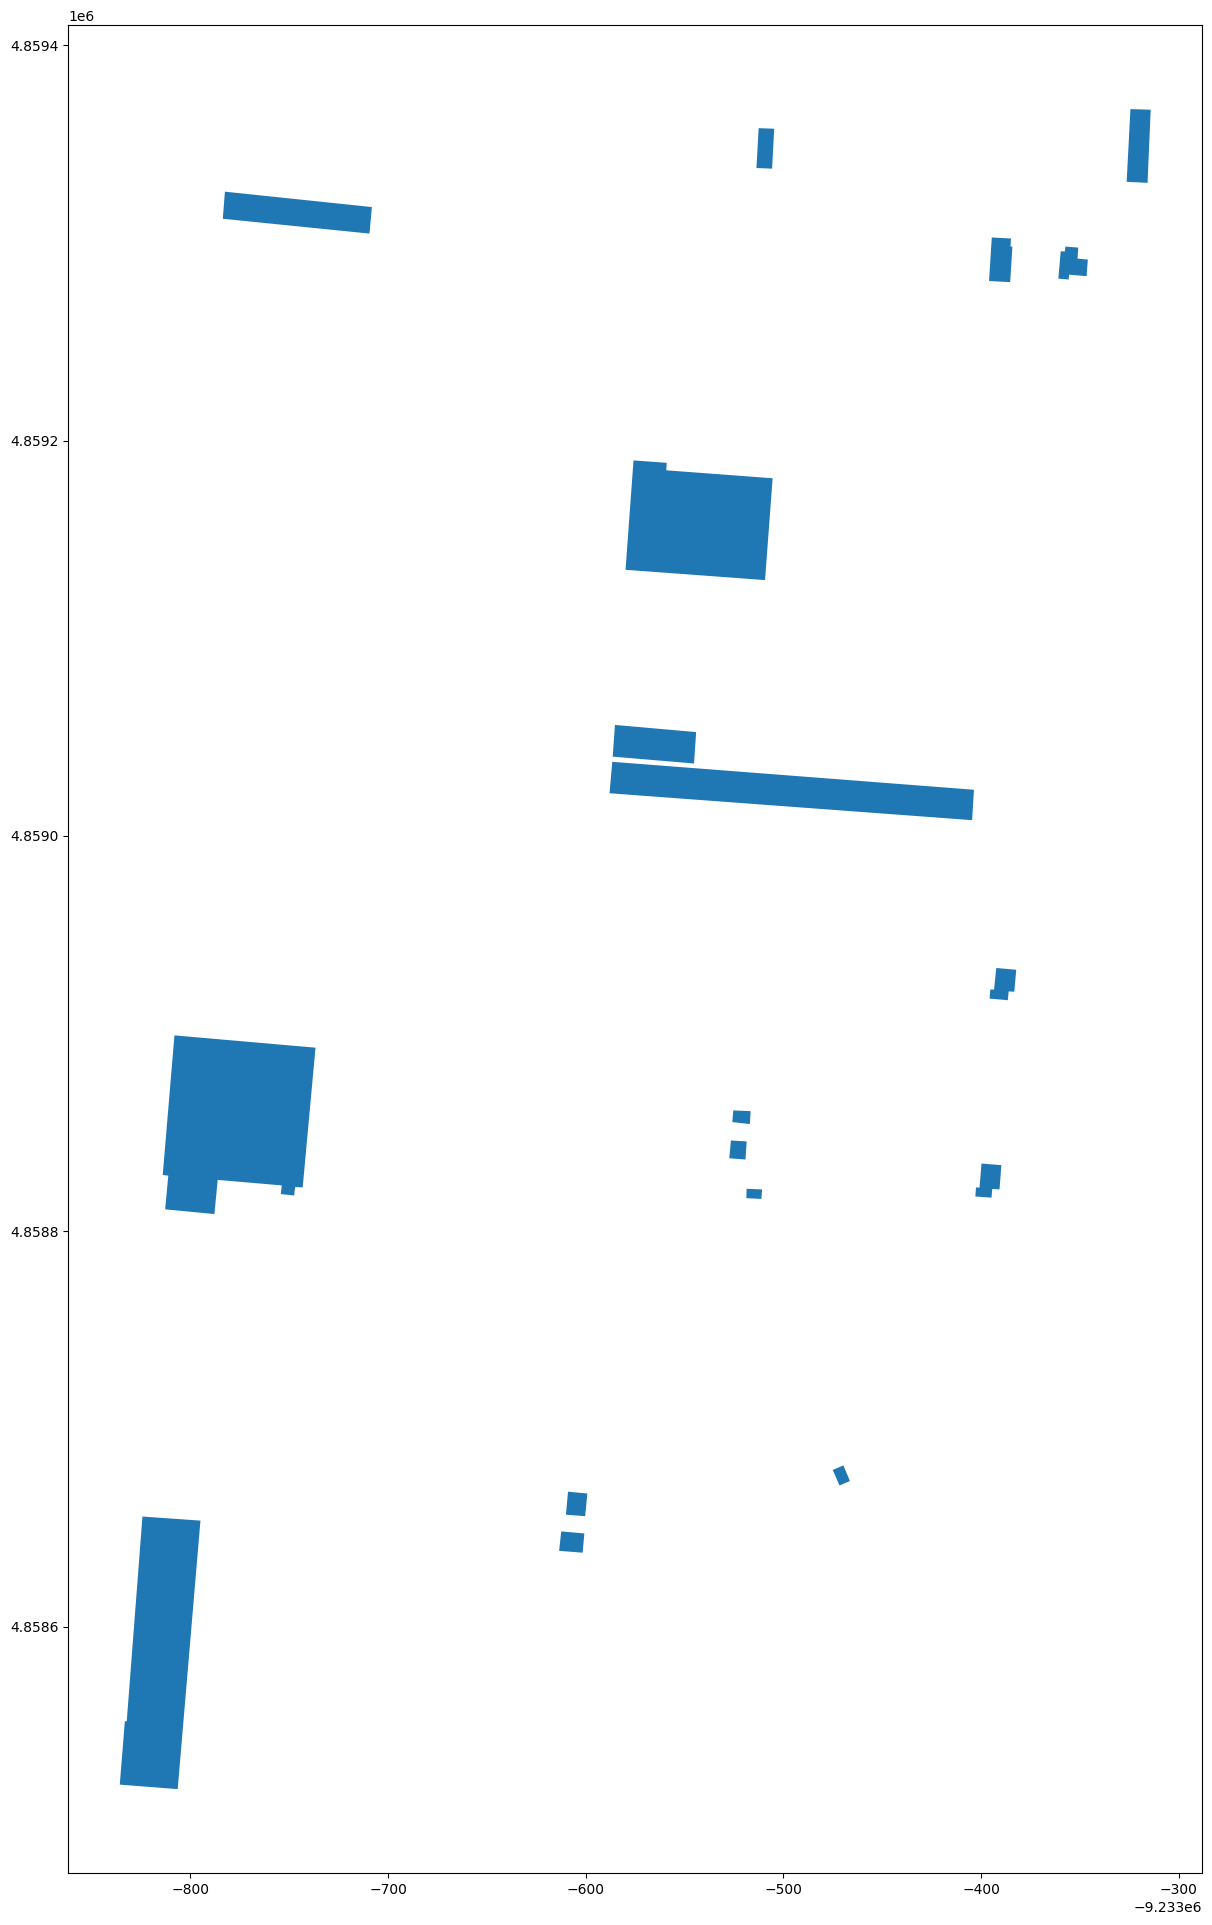

In [5]:
# select only the rows of interest and print the footprint
indices_to_keep = [2,151,155,183,221,224,150,96,79,165,170,178,35,48,87,132,250,0]
reducded_gdf = sim_buildings_ext_gdf.loc[indices_to_keep]
reducded_gdf.plot(figsize=(24,24))

In [6]:
reducded_gdf

,blockID,stories,materials,geometry
2,1869,None,concrete and cinder block,"POLYGON ((-9233783.642 4859312.213, -9233782.5..."
151,760b,None,concrete and cinder block,"POLYGON ((-9233404.567 4859007.961, -9233587.9..."
155,791,1.5,frame or wood,"POLYGON ((-9233395.35 4858922.309, -9233393.44..."
183,827_b,1.5,frame or wood,"POLYGON ((-9233402.605 4858822.141, -9233400.8..."
221,873,1.5,frame or wood,"POLYGON ((-9233608.992 4858668.227, -9233599.2..."
224,879,1.5,frame or wood,"POLYGON ((-9233612.432 4858648.128, -9233600.7..."
150,760a,1,"adobe, metal or iron","POLYGON ((-9233545.25 4859036.632, -9233586.38..."
96,2018_kento,None,concrete and cinder block,"POLYGON ((-9233326.373 4859330.902, -9233324.4..."
79,1993,1.5,frame or wood,"POLYGON ((-9233385.322 4859280.151, -9233396 4..."
165,806_1,1,frame or wood,"POLYGON ((-9233525.4 4858861.122, -9233516.614..."


**1.2 Medial axis construction using scikit-geometry**

In [7]:
def draw_skeleton(polygon, skeleton, show_time=False):
    draw(polygon)

    for h in skeleton.halfedges:
        if h.is_bisector:
            p1 = h.vertex.point
            p2 = h.opposite.vertex.point
            plt.plot([p1.x(), p2.x()], [p1.y(), p2.y()], 'r-', lw=2)

    if show_time:
        for v in skeleton.vertices:
            plt.gcf().gca().add_artist(plt.Circle(
                (v.point.x(), v.point.y()),
                v.time, color='blue', fill=False))

def draw_all_skeletons(polygon, all_skeletons, show_time=False, figsize=(24,24)):
    plt.figure(figsize=figsize)
    draw(polygon, line_width=0.5)
    
    for item in all_skeletons:

        if item is None:
            continue
        
        for h in item.halfedges:
            if h.is_bisector:
                p1 = h.vertex.point
                p2 = h.opposite.vertex.point
                plt.plot([p1.x(), p2.x()], [p1.y(), p2.y()], 'r-', lw=0.5)

        if show_time:
            for v in skeleton.vertices:
                plt.gcf().gca().add_artist(plt.Circle(
                    (v.point.x(), v.point.y()),
                    v.time, color='blue', fill=False))
    return plt

### function #1: Extract poitns from one polygon
def pts_to_skeleton(geom):
    '''
    This function extracts points from a geometry, converts them into a polygon, and draws the skeleton of a geometry. It returns a skeleton graph of a geometry
    '''
    points = []
    for x, y in geom.boundary.coords[:-1]:
        points.append(sg.Point2(x,y))
    points_to_poly = points[::-1] # make sure it is counter-clockwise
    poly_to_skel = sg.Polygon(points_to_poly)
    skeleton = sg.skeleton.create_interior_straight_skeleton(poly_to_skel)
    return skeleton


### function #2: Convert skeleton graphs to networkx graphs
def skeleton2networkx(skeleton):
    geom_vertices = list(skeleton.vertices)
    geom_edges = list(skeleton.halfedges)

    # create an empty graph with no nodes and no edges
    G=nx.Graph()

    # grow undirected (since it adds up from both direction) graph G by adding edge, done by specifying the vertex id at two ends to determine the edge
    for item in geom_edges:
        if item.is_bisector:
            p1 = item.vertex.id # vertex id
            p2 = item.opposite.vertex.id
            G.add_edge(p1, p2)
    #nx.draw(G, with_labels=True)
    return G

In [8]:
# medial axis 
ske_2 = pts_to_skeleton(reducded_gdf.geometry[2])
ske_151 = pts_to_skeleton(reducded_gdf.geometry[151])
ske_155 = pts_to_skeleton(reducded_gdf.geometry[155])
ske_183 = pts_to_skeleton(reducded_gdf.geometry[183])
ske_221 = pts_to_skeleton(reducded_gdf.geometry[221])
ske_224 = pts_to_skeleton(reducded_gdf.geometry[224])
ske_150 = pts_to_skeleton(reducded_gdf.geometry[150])
ske_96 = pts_to_skeleton(reducded_gdf.geometry[96])
ske_79 = pts_to_skeleton(reducded_gdf.geometry[79])
ske_165 = pts_to_skeleton(reducded_gdf.geometry[165])
ske_170 = pts_to_skeleton(reducded_gdf.geometry[170])
ske_178 = pts_to_skeleton(reducded_gdf.geometry[178])
ske_35 = pts_to_skeleton(reducded_gdf.geometry[35])
ske_48 = pts_to_skeleton(reducded_gdf.geometry[48])
ske_87 = pts_to_skeleton(reducded_gdf.geometry[87])
ske_132 = pts_to_skeleton(reducded_gdf.geometry[132])
ske_250 = pts_to_skeleton(reducded_gdf.geometry[250])
ske_0 = pts_to_skeleton(reducded_gdf.geometry[0])

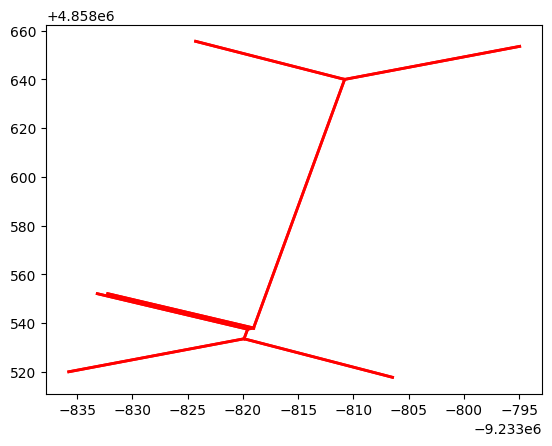

In [9]:
# draw skeleton
# draw_skeleton(reducded_gdf.geometry.iloc[0], ske_2)
# draw_skeleton(reducded_gdf.geometry.iloc[1], ske_151)
# draw_skeleton(reducded_gdf.geometry.iloc[2], ske_155)
# draw_skeleton(reducded_gdf.geometry.iloc[3], ske_183)
# draw_skeleton(reducded_gdf.geometry.iloc[4], ske_221)
# draw_skeleton(reducded_gdf.geometry.iloc[5], ske_224)
# draw_skeleton(reducded_gdf.geometry.iloc[6], ske_150)
# draw_skeleton(reducded_gdf.geometry.iloc[7], ske_96)
# draw_skeleton(reducded_gdf.geometry.iloc[8], ske_79)
# draw_skeleton(reducded_gdf.geometry.iloc[9], ske_165)
# draw_skeleton(reducded_gdf.geometry.iloc[10], ske_170)
# draw_skeleton(reducded_gdf.geometry.iloc[11], ske_178)
# draw_skeleton(reducded_gdf.geometry.iloc[12], ske_35)
# draw_skeleton(reducded_gdf.geometry.iloc[13], ske_48)
# draw_skeleton(reducded_gdf.geometry.iloc[14], ske_87)
# draw_skeleton(reducded_gdf.geometry.iloc[15], ske_132)
# draw_skeleton(reducded_gdf.geometry.iloc[16], ske_250)
draw_skeleton(reducded_gdf.geometry.iloc[17], ske_0)

**1.3 From Medial Axis to Graphs**

In [10]:
# create networkx graphs
gs_2 = skeleton2networkx(ske_2)
gs_151 = skeleton2networkx(ske_151)
gs_155 = skeleton2networkx(ske_155)
gs_183 = skeleton2networkx(ske_183)
gs_221 = skeleton2networkx(ske_221)
gs_224 = skeleton2networkx(ske_224)
gs_150 = skeleton2networkx(ske_150)
gs_96 = skeleton2networkx(ske_96)
gs_79 = skeleton2networkx(ske_79)
gs_165 = skeleton2networkx(ske_165)
gs_170 = skeleton2networkx(ske_170)
gs_178 = skeleton2networkx(ske_178)
gs_35 = skeleton2networkx(ske_35)
gs_48 = skeleton2networkx(ske_48)
gs_87 = skeleton2networkx(ske_87)
gs_132 = skeleton2networkx(ske_132)
gs_250 = skeleton2networkx(ske_250)
gs_0 = skeleton2networkx(ske_0)

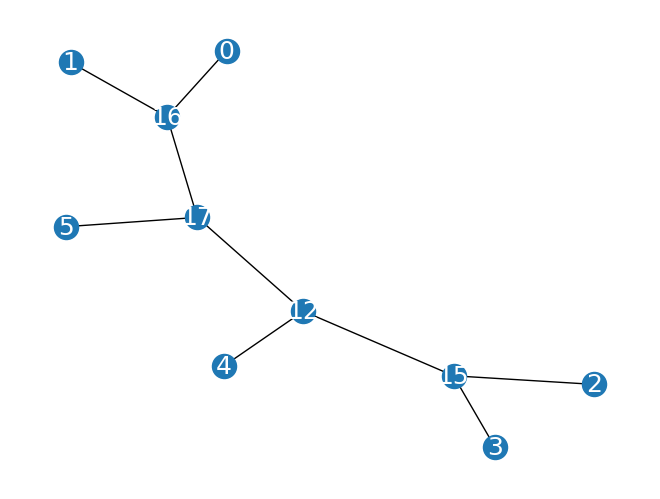

In [11]:
# draw networkx graphs
# nx.draw(gs_2, with_labels=True, font_size=18, font_color='white')
# nx.draw(gs_151, with_labels=True, font_size=18, font_color='white')
# nx.draw(gs_155, with_labels=True, font_size=18, font_color='white')
# nx.draw(gs_183, with_labels=True, font_size=18, font_color='white')
# nx.draw(gs_221, with_labels=True, font_size=18, font_color='white')
# nx.draw(gs_224, with_labels=True, font_size=18, font_color='white')
# nx.draw(gs_150, with_labels=True, font_size=18, font_color='white')
# nx.draw(gs_96, with_labels=True, font_size=18, font_color='white')
# nx.draw(gs_79, with_labels=True, font_size=18, font_color='white')
# nx.draw(gs_165, with_labels=True, font_size=18, font_color='white')
# nx.draw(gs_170, with_labels=True, font_size=18, font_color='white')
# nx.draw(gs_178, with_labels=True, font_size=18, font_color='white')
# nx.draw(gs_35, with_labels=True, font_size=18, font_color='white')
# nx.draw(gs_48, with_labels=True, font_size=18, font_color='white')
# nx.draw(gs_87, with_labels=True, font_size=18, font_color='white')
# nx.draw(gs_132, with_labels=True, font_size=18, font_color='white')
# nx.draw(gs_250, with_labels=True, font_size=18, font_color='white')
nx.draw(gs_0, with_labels=True, font_size=18, font_color='white')

In [12]:
# from networkx graphs to igraph graphs
ig_2 = ig.Graph.from_networkx(gs_2)
ig_151 = ig.Graph.from_networkx(gs_151)
ig_155 = ig.Graph.from_networkx(gs_155)
ig_183 = ig.Graph.from_networkx(gs_183)
ig_221 = ig.Graph.from_networkx(gs_221)
ig_224 = ig.Graph.from_networkx(gs_224)
ig_150 = ig.Graph.from_networkx(gs_150)
ig_96 = ig.Graph.from_networkx(gs_96)
ig_79 = ig.Graph.from_networkx(gs_79)
ig_165 = ig.Graph.from_networkx(gs_165)
ig_170 = ig.Graph.from_networkx(gs_170)
ig_178 = ig.Graph.from_networkx(gs_178)
ig_35 = ig.Graph.from_networkx(gs_35)
ig_48 = ig.Graph.from_networkx(gs_48)
ig_87 = ig.Graph.from_networkx(gs_87)
ig_132 = ig.Graph.from_networkx(gs_132)
ig_250 = ig.Graph.from_networkx(gs_250)
ig_0 = ig.Graph.from_networkx(gs_0)

subset_igraphs = [ig_2, ig_151, ig_155, ig_183, ig_221, ig_224, ig_150,
                  ig_96, ig_79, ig_165, ig_170, ig_178, ig_35, ig_48,
                  ig_87, ig_132, ig_250, ig_0]

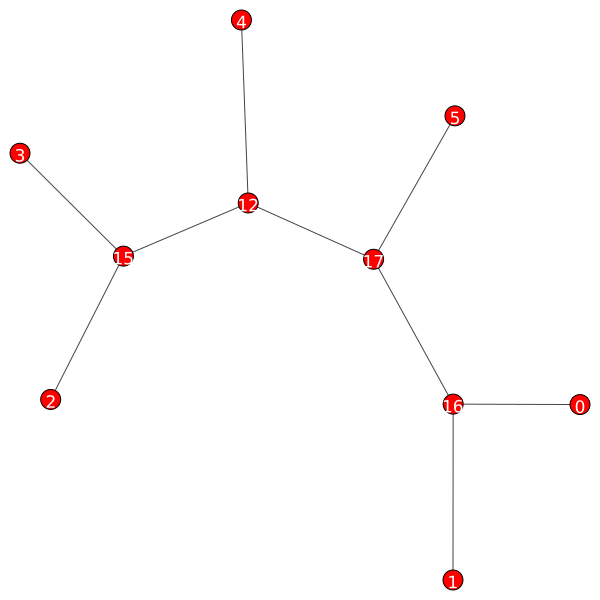

In [13]:
# draw igraph graphs
# ig.plot(ig_2,
#         vertex_label=ig_2.vs["_nx_name"],
#         vertex_label_size=17,
#         vertex_label_color="white")

# ig.plot(ig_151,
#         vertex_label=ig_151.vs["_nx_name"],
#         vertex_label_size=17,
#         vertex_label_color="white")

# ig.plot(ig_155,
#         vertex_label=ig_155.vs["_nx_name"],
#         vertex_label_size=17,
#         vertex_label_color="white")

# ig.plot(ig_183,
#         vertex_label=ig_183.vs["_nx_name"],
#         vertex_label_size=17,
#         vertex_label_color="white")

# ig.plot(ig_221,
#         vertex_label=ig_221.vs["_nx_name"],
#         vertex_label_size=17,
#         vertex_label_color="white")

# ig.plot(ig_224,
#         vertex_label=ig_224.vs["_nx_name"],
#         vertex_label_size=17,
#         vertex_label_color="white")

# ig.plot(ig_150,
#         vertex_label=ig_150.vs["_nx_name"],
#         vertex_label_size=17,
#         vertex_label_color="white")

# ig.plot(ig_96,
#         vertex_label=ig_96.vs["_nx_name"],
#         vertex_label_size=17,
#         vertex_label_color="white")

# ig.plot(ig_79,
#         vertex_label=ig_79.vs["_nx_name"],
#         vertex_label_size=17,
#         vertex_label_color="white")

# ig.plot(ig_165,
#         vertex_label=ig_165.vs["_nx_name"],
#         vertex_label_size=17,
#         vertex_label_color="white")

# ig.plot(ig_170,
#         vertex_label=ig_170.vs["_nx_name"],
#         vertex_label_size=17,
#         vertex_label_color="white")

# ig.plot(ig_178,
#         vertex_label=ig_178.vs["_nx_name"],
#         vertex_label_size=17,
#         vertex_label_color="white")

# ig.plot(ig_35,
#         vertex_label=ig_35.vs["_nx_name"],
#         vertex_label_size=17,
#         vertex_label_color="white")

# ig.plot(ig_48,
#         vertex_label=ig_48.vs["_nx_name"],
#         vertex_label_size=17,
#         vertex_label_color="white")

# ig.plot(ig_87,
#         vertex_label=ig_87.vs["_nx_name"],
#         vertex_label_size=17,
#         vertex_label_color="white")

# ig.plot(ig_132,
#         vertex_label=ig_132.vs["_nx_name"],
#         vertex_label_size=17,
#         vertex_label_color="white")

# ig.plot(ig_250,
#         vertex_label=ig_250.vs["_nx_name"],
#         vertex_label_size=17,
#         vertex_label_color="white")

ig.plot(ig_0,
        vertex_label=ig_0.vs["_nx_name"],
        vertex_label_size=17,
        vertex_label_color="white")

## PART II: Clustering

### **Step 1: Graph Embedding - From skeleton to graph features**

**2.1 Compute the edge weights and node weightst**

- ***Edge weights***

In [14]:
subset_ske = [ske_2,ske_151,ske_155,ske_183,ske_221,ske_224,ske_150,
              ske_96, ske_79, ske_165, ske_170, ske_178, ske_35, ske_48,
              ske_87, ske_132, ske_250, ske_0]

len(subset_ske)

18

In [15]:
# computing edge weight
subset_weights = []
for skeleton in subset_ske:
    sub_weights = {}
    for edge in skeleton.halfedges:
        if edge.is_bisector:
            u1_pt = edge.vertex.point
            u2_pt = edge.opposite.vertex.point
            u1_vertex = edge.vertex
            u2_vertex = edge.opposite.vertex
            d_u1u2 = math.sqrt((u2_pt.x()-u1_pt.x())**2 + (u2_pt.y()-u1_pt.y())**2)
            sub_weights[(u1_vertex.id, u2_vertex.id)] = d_u1u2 
    subset_weights.append(sub_weights)


#len(subset_weights)
subset_weights

[{(8, 0): 9.592372510200464,
  (0, 8): 9.592372510200464,
  (8, 1): 9.477622524738061,
  (1, 8): 9.477622524738061,
  (9, 2): 9.828968775352473,
  (2, 9): 9.828968775352473,
  (9, 3): 9.590794156831556,
  (3, 9): 9.590794156831556,
  (9, 8): 61.051472859698656,
  (8, 9): 61.051472859698656},
 {(8, 0): 10.825321437569102,
  (0, 8): 10.825321437569102,
  (9, 1): 11.216861761842821,
  (1, 9): 11.216861761842821,
  (9, 2): 11.344539218341213,
  (2, 9): 11.344539218341213,
  (8, 3): 10.988968939013212,
  (3, 8): 10.988968939013212,
  (9, 8): 168.03575428291714,
  (8, 9): 168.03575428291714},
 {(16, 0): 3.3279101195897405,
  (0, 16): 3.3279101195897405,
  (23, 1): 5.235058469565962,
  (1, 23): 5.235058469565962,
  (20, 2): 5.155705668105134,
  (2, 20): 5.155705668105134,
  (25, 3): 7.13710399428437,
  (3, 25): 7.13710399428437,
  (24, 4): 7.227778658082617,
  (4, 24): 7.227778658082617,
  (24, 5): 7.17248614836995,
  (5, 24): 7.17248614836995,
  (17, 6): 3.3083565477087227,
  (6, 17): 3.3083

- ***Node weights***

In [16]:
# construct node features
subset_node_ls_dict = []
for skeleton in subset_ske:
    sub_node_ls_dict = {}
    for i in list(skeleton.vertices):
        sub_node_ls_dict[i.id] = i.time
    subset_node_ls_dict.append(sub_node_ls_dict)

subset_node_ls_dict

[{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 6.747976774744137, 9: 6.858177803181223},
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 7.717659342542857, 9: 7.970279119009592},
 {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  16: 2.3614898254273764,
  17: 2.4022004055480504,
  20: 3.6962269386643727,
  23: 3.7108423678850366,
  24: 5.103631623907486,
  25: 5.108941533920166},
 {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  16: 2.3371013458572967,
  17: 2.373681225754804,
  20: 3.2312896833802536,
  21: 3.2363647602397236,
  24: 5.060018340113934,
  25: 5.065319324913257},
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 4.888695302487665, 9: 4.893198549951605},
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 4.911331003065985, 9: 4.917286909022391},
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 7.973821542236915, 9: 8.02165529786532},
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 5.1435423819016135, 9: 5.263920625984242},
 {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.

In [17]:
# normalize the node_ls
all_max_x_list = []
all_min_x_list = []
for item in subset_node_ls_dict:
    for key, value in item.items():
        max_x = max(item.values())
        min_x = min(item.values())
        all_max_x_list.append(max_x)
        all_min_x_list.append(min_x)
    upper_x = max(all_max_x_list)
    lower_x = min(all_min_x_list)
print(f'max: {upper_x}')
print(f'min: {lower_x}')  

for item in subset_node_ls_dict:
    for key, value in item.items():
        #print(f'value:{value}')
        item[key] = value/upper_x

print(f'after{subset_node_ls_dict}')

max: 35.462918304432826
min: 0.0
after[{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 0.19028261342780262, 9: 0.19339011370431852}, {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 0.21762617718852983, 9: 0.224749668106511}, {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 16: 0.06659039747251125, 17: 0.06773837350119541, 20: 0.10422794049079566, 23: 0.1046400732175836, 24: 0.14391459778056498, 25: 0.14406432911308242}, {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 16: 0.065902679689087, 17: 0.06693417629586611, 20: 0.09111742174293495, 21: 0.0912605311400777, 24: 0.1426847699525461, 25: 0.142834249607712}, {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 0.1378537225989262, 9: 0.13798070728262543}, {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 0.1384920146984089, 9: 0.1386599621274749}, {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 0.22484955901782613, 9: 0.22619839768975308}, {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 8: 0.14504002004986363, 9: 0.14843450222556157}, {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 

- ***Plot igraph graphs with with weights***

In [18]:
# ig_0.es[5].tuple # return 3,6
# ig_0.vs[3]["_nx_name"],ig_0.vs[6]["_nx_name"] # return 15,12

In [19]:
def igraph_edge_paired_vertices(graph,ite):
    '''
    input: igraph.Graph
    ite: iteration of edge in int
    output: pair of vertices in tuple
    '''
    v1,v2 = graph.es[ite].tuple
    paired_vertices = graph.vs[v1]["_nx_name"],graph.vs[v2]["_nx_name"]
    return paired_vertices

In [20]:
def igraph_node_weight(graph, node_dict):
    '''
    input1: igraph.Graph
    input2: dict of node where the key is node label ("_nx_name") and the value is the node weight
    output: list of dict where the key is the node label of the igraph.Graph and the value is the node weight
    '''
    g_weight = []
    for v in graph.vs["_nx_name"]:
        value = node_dict[v]
        g_weight.append({v:round(value,3)})
    return g_weight

In [21]:
def igraph_node_edge_wt_plot(graph, node_dict, weights):
    vertex_labels=igraph_node_weight(graph,node_dict)
    #print(vertex_labels)
    edge_label_ls = []
    for ite in range(len(graph.es)):
        edge_tuple = igraph_edge_paired_vertices(graph,ite)
        edge_label = round(weights[edge_tuple],3)
        edge_label_ls.append(edge_label)   
    #print(edge_label_ls)

    return vertex_labels, edge_label_ls

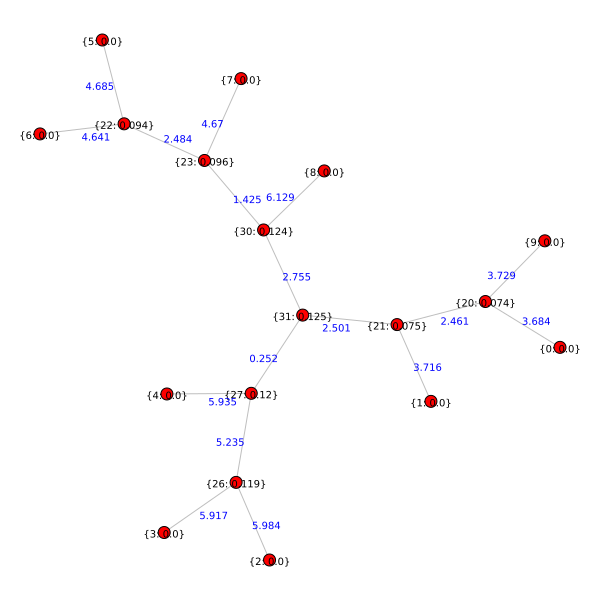

In [53]:
vertex_wt_ig, edge_label_ls_ig = igraph_node_edge_wt_plot(subset_igraphs[14],subset_node_ls_dict[14],subset_weights[14])
ig.plot(ig_87,
        vertex_label=vertex_wt_ig,
        vertex_label_size=10,
        vertex_label_color="black",
        vertex_size=12,
        vertex_color="red", 
        edge_label=edge_label_ls_ig,
        edge_label_size=10,
        edge_label_color="blue",
        edge_color="gray",
        margin=40)

### **Step 2: Continuous Weisfeiler-Lehman and Wasserstein Distance Computation**

In [23]:
# compute the kernel
kernel_matrix, weighted_label_sequences = wwl(subset_igraphs,node_features=subset_node_ls_dict, edge_weight=subset_weights, num_iterations=4)

INFO:root:Continuous node features provided, using CONTINUOUS propagation scheme.


g1:0,g2:0,distance:0.0
g1:0,g2:1,distance:0.01645479419390229
g1:0,g2:2,distance:0.04739361645296319
g1:0,g2:3,distance:0.049934677527764766
g1:0,g2:4,distance:0.027252613638212637
g1:0,g2:5,distance:0.02691614214269304
g1:0,g2:6,distance:0.022211132422029902
g1:0,g2:7,distance:0.025789594787453074
g1:0,g2:8,distance:0.03333558841749459
g1:0,g2:9,distance:0.0580928702676613
g1:0,g2:10,distance:0.03995162151712282
g1:0,g2:11,distance:0.07092641671291694
g1:0,g2:12,distance:0.061912305607451465
g1:0,g2:13,distance:0.046061354718184316
g1:0,g2:14,distance:0.05051406098236443
g1:0,g2:15,distance:0.22619270152507195
g1:0,g2:16,distance:0.21497188337587333
g1:0,g2:17,distance:0.18369948770733474
g1:1,g2:1,distance:0.0
g1:1,g2:2,distance:0.062172673310362615
g1:1,g2:3,distance:0.06528467164398563
g1:1,g2:4,distance:0.042655952770556546
g1:1,g2:5,distance:0.04240052060236987
g1:1,g2:6,distance:0.007609355432100838
g1:1,g2:7,distance:0.04223648284425041
g1:1,g2:8,distance:0.0471878746121398
g1:

In [24]:
weighted_label_sequences

[array([[0.        , 0.04757065, 0.03288106, 0.02469955, 0.019766  ],
        [0.        , 0.04757065, 0.03288106, 0.02469955, 0.019766  ],
        [0.        , 0.04834753, 0.03339961, 0.02507479, 0.02005525],
        [0.        , 0.04834753, 0.03339961, 0.02507479, 0.02005525],
        [0.19028261, 0.05107252, 0.03298441, 0.02471545, 0.01977654],
        [0.19339011, 0.05185129, 0.03346651, 0.02506333, 0.02004466]]),
 array([[0.        , 0.05440654, 0.03685974, 0.02765875, 0.02213259],
        [0.        , 0.05618742, 0.03804723, 0.02853537, 0.02282269],
        [0.        , 0.05618742, 0.03804723, 0.02853537, 0.02282269],
        [0.        , 0.05440654, 0.03685974, 0.02765875, 0.02213259],
        [0.21762618, 0.05617268, 0.03689691, 0.02767274, 0.02214344],
        [0.22474967, 0.05795428, 0.03804707, 0.02852136, 0.02281148]]),
 array([[0.        , 0.0166476 , 0.0137241 , 0.01128104, 0.00953985],
        [0.        , 0.02616002, 0.02268548, 0.01831037, 0.01493627],
        [0.     

In [25]:
def igraph_node_WL_label_prop(graph, weighted_label_seq):
    '''
    input1: igraph.Graph
    input2: list of list of list of vertex
    output: list of dict where the key is the node label of the igraph.Graph and the value is the node of WL label prop
    '''
    before_sort = graph.vs["_nx_name"]
    g_weight = [None]*len(before_sort)
    after_sort = sorted(before_sort)
    #print(before_sort)
    #print(after_sort)
    #print(weighted_label_seq)
    for i in range(len(after_sort)):
        index = before_sort.index(after_sort[i])
        g_weight[index] = weighted_label_seq[i]
    return g_weight

In [26]:
def igraph_WL(graph, weighted_label_seq, weights):
    vertex_labels=igraph_node_WL_label_prop(graph,weighted_label_seq)
    #print(vertex_labels)
    edge_label_ls = []
    for ite in range(len(graph.es)):
        edge_tuple = igraph_edge_paired_vertices(graph,ite)
        edge_label = round(weights[edge_tuple],3)
        edge_label_ls.append(edge_label)   
    #print(edge_label_ls)

    return vertex_labels, edge_label_ls

In [27]:
vertex_wt_ig

[{9: 0.139}, {0: 0.0}, {8: 0.138}, {1: 0.0}, {2: 0.0}, {3: 0.0}]

In [28]:
vertices_ls = []
for item in vertex_wt_ig:
    rounded = [round(float(v), 3) for v in item]
    vertices_ls.append(str(rounded))

vertices_ls

['[9.0]', '[0.0]', '[8.0]', '[1.0]', '[2.0]', '[3.0]']

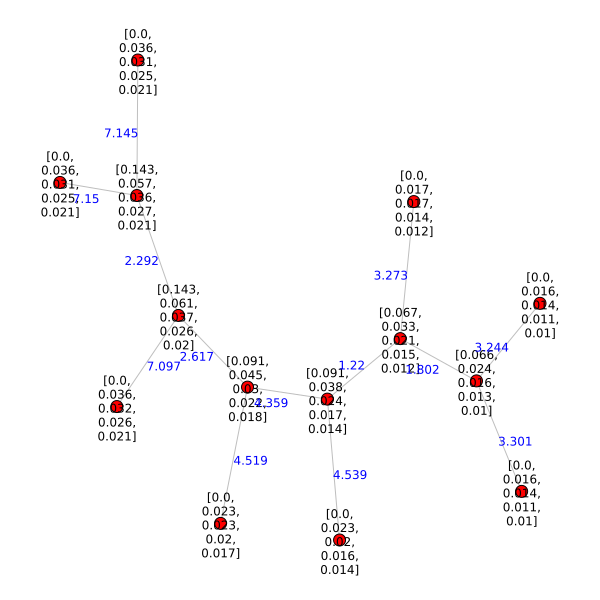

In [59]:
vertex_wt_ig, edge_label_ls_ig = igraph_WL(subset_igraphs[3],weighted_label_sequences[3],subset_weights[3])

vertices_ls = []
for item in vertex_wt_ig:
    rounded = [round(float(v), 3) for v in item]
    stringed = str(rounded).replace(" ", "\n")
    vertices_ls.append(stringed)

vertices_ls

ig.plot(ig_183,
        vertex_label=vertices_ls,
        vertex_label_size=12,
        vertex_label_color="black",
        vertex_size=12,
        vertex_color="red", 
        edge_label=edge_label_ls_ig,
        edge_label_size=12,
        edge_label_color="blue",
        edge_color="gray",
        margin=60)

In [ ]:
ig_2.vs["_nx_name"]

In [ ]:
sorted(ig_2.vs["_nx_name"])